In [1]:
# Incident_flux is a Python 3 program designed to model the Incident Radiative Flux
# on the top of a planetary atmosphere taking into consideration orbital paramaters including
# obliquity, eccentricity and orbital phase. 
# Authors James O'Connor and Dag Evensberget from the University of Southern Queensland
# Contact email: James.OConnor@usq.edu.au 
# input parameters are commented and these can be modified to map incident radiative flux

import numpy as np 
from PyAstronomy import pyasl
import matplotlib.pylab as plt
au = 1.496e11 # This is Astronomical Units in metres
solarluminosity = 3.848e26 # This is a constant
stellarluminosity = 1*solarluminosity # This value is changed according to the star

# Replicate a Keplerian elliptical orbit with a
# semi-major axis in AU converted to metres m,
# a period of 1 time unit, eccentricity e,
# longitude of ascending node of x degrees, an inclination (which is the orientation of the orbit)
# of y deg, and a periapsis argument of z deg. This segment of code is courtesy PyAstronomy
# Here we can change the eccentricity and the semi major axis and inclinations eg 10, 20, 50 degrees
target_name = 'Earth'
ke = pyasl.KeplerEllipse(1.000*au, #semi-major axis of the target exoplanet
                         1., #the time period set as 1 which is not changed
                         e=0.01671022, #eccentricity
                         Omega=0, #not used and is the longitude of the ascending node
                         i=0.00005, #inclination of the exoplanet in degrees
                         w=90) #is the argument of periastrom of the orbit in degrees or longitude of perihelion
t = np.linspace(0, 1, 500)
pos = ke.xyzPos(t)
# the t line creates a set of points which are time values between 0 and 1
print(ke)
plt.plot(pos[:,0], pos[:,2], 'r.')
# pos is the position and then this . gets plotted continuously 
# changing the plt.plot pos positions changes the viewing angle 
plt.plot(0, 0, 'o')
plt.show()
print("%s: a=%2.3f AU, e=%2.1f, Omega=%2.1f deg, i=%2.1f deg, w=%2.1f deg" %(target_name, ke.a/au, ke.e, ke.Omega, ke.i, ke.w))

<Figure size 640x480 with 1 Axes>

Earth: a=1.000 AU, e=0.0, Omega=0.0 deg, i=0.0 deg, w=90.0 deg


Text(0, 0.5, 'Radius in metres')

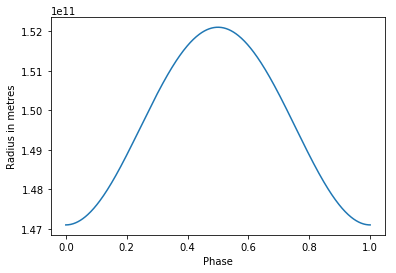

In [2]:
radius = ke.radius(t)

plt.plot(t, radius)
plt.xlabel('Phase')
plt.ylabel('Radius in metres')

In [3]:
# time, lat, lon, 3
# this section creates x, y and z coordinates
# geometrically we have simplified here because radius of the exoplanet << radius of the orbit
polar, azimuth = np.meshgrid(np.linspace(0, np.pi, 221), np.linspace(0, 2*np.pi, 201))

def xyz(polar, azimuth):
    x = np.sin(polar) * np.cos(azimuth)
    y = np.sin(polar) * np.sin(azimuth)
    z = np.cos(polar)

    return x, y, z

x, y, z = xyz(polar, azimuth)



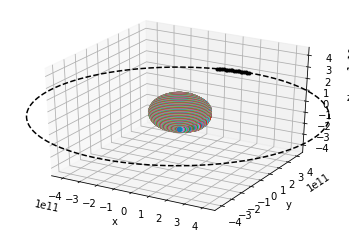

In [4]:
# this plots a 3 dimensional plot of the movement of the star with respect to the planet
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for _id in range(0,x.shape[1]):
    c = plt.plot(au*x[:, _id], au*y[:, _id], au*z[:, _id])
    plt.plot(au*x[0:20, _id], au*y[0:20, _id], au*z[0:20, _id], '.', color=c[0].get_color())
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
# lines of latitude are plotted as a circle which verifies the geometrical representation
# this code shows the star trajectory as seen from the exoplanet with visual exaggeration of exoplanet radius
c = plt.plot(5*pos[:,0], 5*pos[:,1], 5*pos[:,2], 'k--')
plt.plot(5*pos[0:20,0], 5*pos[0:20,1], 5*pos[0:20,2], '.', color=c[0].get_color())
lims = [-3*au,3*au]
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_zlim(lims)
plt.show()

In [5]:
# This section calculates the insolation (flux)
insolation = np.zeros_like(x)
insolation = np.tile(insolation, (len(t), 1, 1))

# flux_at_perigee = stellarluminosity/(4*np.pi*)
# this value of 1 is chosen arbitrarily and will be changed to the physical value at perigee and this will be 
# calculated using luminosity eg for TRAPPIST-1 the Luminosity is -3.28 on the NASA Exoplanet Archive.
# radius_at_pergigee = np.min(radius)
# implement offset in phase between the periastron (this is satisfied see below)
# and the highest solar declination in the Northern hemisphere is mentioned by Kane and Torres and this relates to w

for _polar_id in range(polar.shape[0]):
    for _azimuth_id in range(polar.shape[1]):
        
        _x = x[_polar_id, _azimuth_id]
        _y = y[_polar_id, _azimuth_id]
        _z = z[_polar_id, _azimuth_id]

        p = np.array([_x, _y, _z])
        
        flux = stellarluminosity/(4*np.pi*radius**2)
        insolation[:, _polar_id, _azimuth_id] = flux* ((pos / radius[:, None]) @ p)
        

sun_visible = insolation > -1e-6 # this allows correction of negative values when the star is down 
insolation_positive = insolation * sun_visible


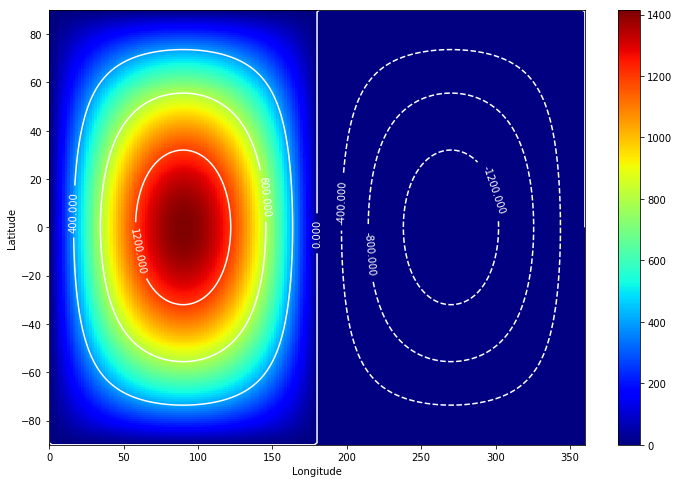

In [6]:
#
# Test Plot
#

fig, ax = plt.subplots(figsize=(12,8))

lon = np.rad2deg(azimuth)
lat = 90 - np.rad2deg(polar)

# Draw the colours
img = plt.pcolormesh(
    lon, 
    lat, 
    insolation_positive[0, ...],
    cmap='jet')
cbar = plt.colorbar(img)

# Draw the contours
cs = plt.contour(
    lon, 
    lat, 
    insolation[0, ...], 
    colors='white')
plt.clabel(cs, inline=1, fontsize=10)

plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

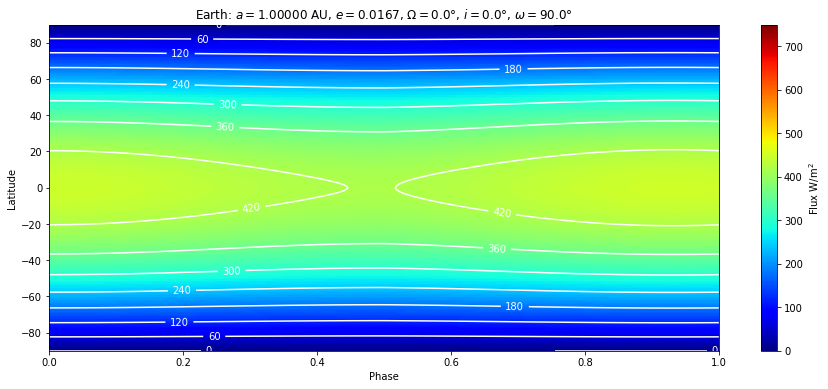

Earth: a=1.00000 AU, e=0.0167, Omega=0.0 deg, i=0.0 deg, w=90.0 deg


In [7]:
#
# Real Plot
#
fig, ax = plt.subplots(figsize=(15,6))

lon = np.rad2deg(azimuth)
lat = 90 - np.rad2deg(polar)

# Draw the colours
img = plt.pcolormesh(
    t, 
    lat[0,:], 
    np.average(insolation_positive, axis=1).transpose(), cmap='jet', vmin=0, vmax=750)  #uniform visual representation
cbar = plt.colorbar(img)

# Draw the contours
cs = plt.contour(
    t, 
    lat[0,:], 
    np.average(insolation_positive, axis=1).transpose(),
    colors='white')
plt.clabel(cs, inline=1, fontsize=10, fmt='%1.0f')

plt.xlabel('Phase')
plt.ylabel('Latitude')
cbar.set_label('Flux W/m$^2$')
descr = "%s: a=%2.5f AU, e=%2.4f, Omega=%2.1f deg, i=%2.1f deg, w=%2.1f deg" %(target_name, ke.a/au, ke.e, ke.Omega, ke.i, ke.w)
plt.title("%s: $a=%2.5f$ AU, $e=%2.4f$, $\Omega=%2.1f \degree$, $i=%2.1f \degree$, $\omega=%2.1f \degree$" %(target_name, ke.a/au, ke.e, ke.Omega, ke.i, ke.w))
fig_file_name = descr.replace(':', '_').replace(',', '').replace(' ','_') + '.png'
plt.savefig(fig_file_name)
plt.show()
print(descr)

In [8]:
# this plots a 3 dimensional plot 
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
#
#fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
#
# Plot the surface
#surf = ax.plot_surface(
#    lat[0,:], 
#    np.average(insolation_positive, axis=1).transpose())